# Diabetes Onset Detection -- Data Cleaning

## Goal
1. Download data from [data.world](https://data.world/data-society/pima-indians-diabetes-database)
2. Perform data cleaning

### Importing useful packages

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# supress warnings
import warnings
warnings.filterwarnings("ignore")

sns.set()
sns.set_style("whitegrid")

### Loading data

In [28]:
diabetes_raw = pd.read_csv('../Data/diabetes.csv')

In [29]:
# check the shape of the data
diabetes_raw.shape

(768, 9)

In [30]:
# display the first few examples of raw data, set the pandas options to display all columns
pd.set_option('display.max_columns', len(diabetes_raw.columns))
diabetes_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [31]:
# check the data type in each column
diabetes_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


From above, it looks like our dataset are all consisted of numeric values, let us summarize the data using `df.describe()` 

In [32]:
diabetes_raw.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


It looks like there are some features that have minimum value 0 that does not really make sense, for example, `SkinThickness`, `BMI` and `Glucose` should never be 0 no matter how low the value is, we will check the number of 0 value in each column first.

In [33]:
# display number of 0 in each column
(diabetes_raw == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

We can see there do exists 0 values in most of the columns, as mentioned, it does not make sense in some of the features that have 0 value, we could simply conclude that should be a missing value instead of a true numerical 0 here, we will transform the 0s in those columns into NaN, this includes the following columns: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` and `BMI`.

In [34]:
# replacing 0 with missing values
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# make a copy of the original raw data
diabetes_nan = diabetes_raw.copy()
diabetes_nan[cols] = diabetes_nan[cols].replace(0, np.nan)

In [35]:
# check the result to see if it matches
diabetes_nan[cols].isnull().sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

### Dealing with missing value
The simplest way to deal with missing value is to drop the examples that has any missing value in those five columns mentioned above, another way is to impute it, we will use both approaches for future use of our model

#### Approach 1 -- Drop the examples with missing values

In [36]:
diabetes1 = diabetes_nan.dropna()

In [37]:
# check the shape of the resulting dataframe
diabetes1.shape

(392, 9)

We can see that by using approach1, we missed around 49% of the data, this is nearly half of our original dataset, which might not be a good approach

#### Approach 2 -- Imputing missing values

First of all, let us find out the distribution of missing values in each column to get a better understanding of the dataset, we will import the `missingno` module

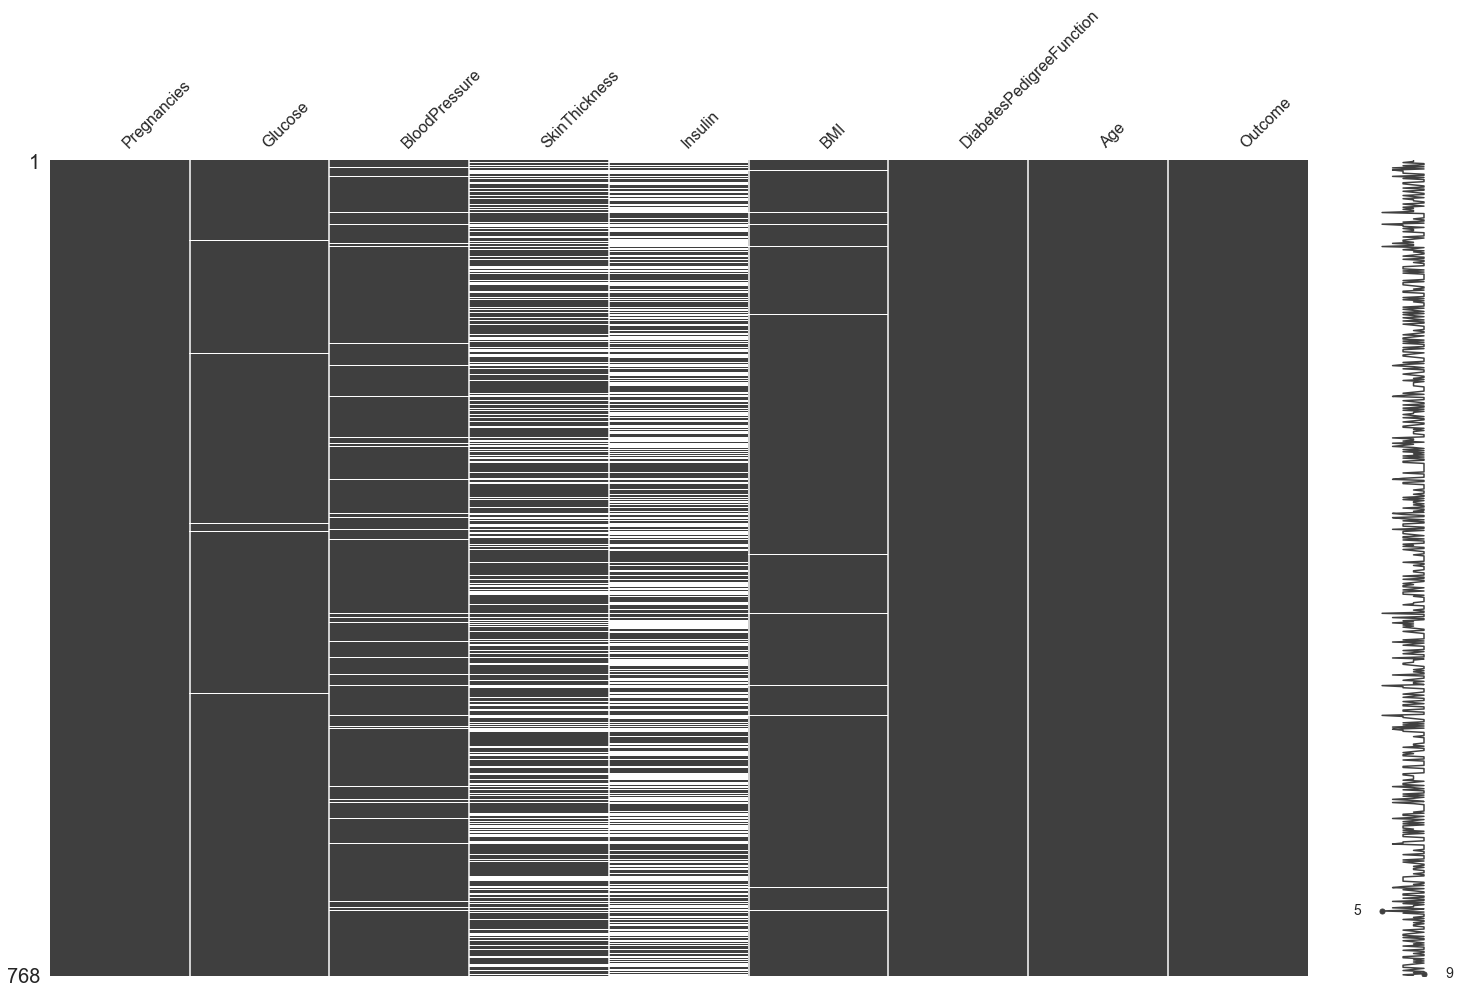

In [38]:
import missingno as msno

ax = msno.matrix(diabetes_nan, figsize=(25,15))
plt.show()

We can see that there is no particular pattern of missing value distribution, we will use the imputer package from sklearn module to deal with missing value, to deal with missing value for numerical feature, the most common methods are using mean and median, we will try both for our future model, but since the mean will be highly affected by the outliers of the dataset, we need to deal with the outliers first before performing the imputation

### Dealing with outliers
An outlier is a data point in a data set that is distant from all other observations, the existance of outlier can skew the data and have significant impact on mean and standard deviation, this could affect the accuracy of our predicting model. The criteria to identify an outlier is usually a data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile, we will use the boxplot to identify if there is any outliers in each column.

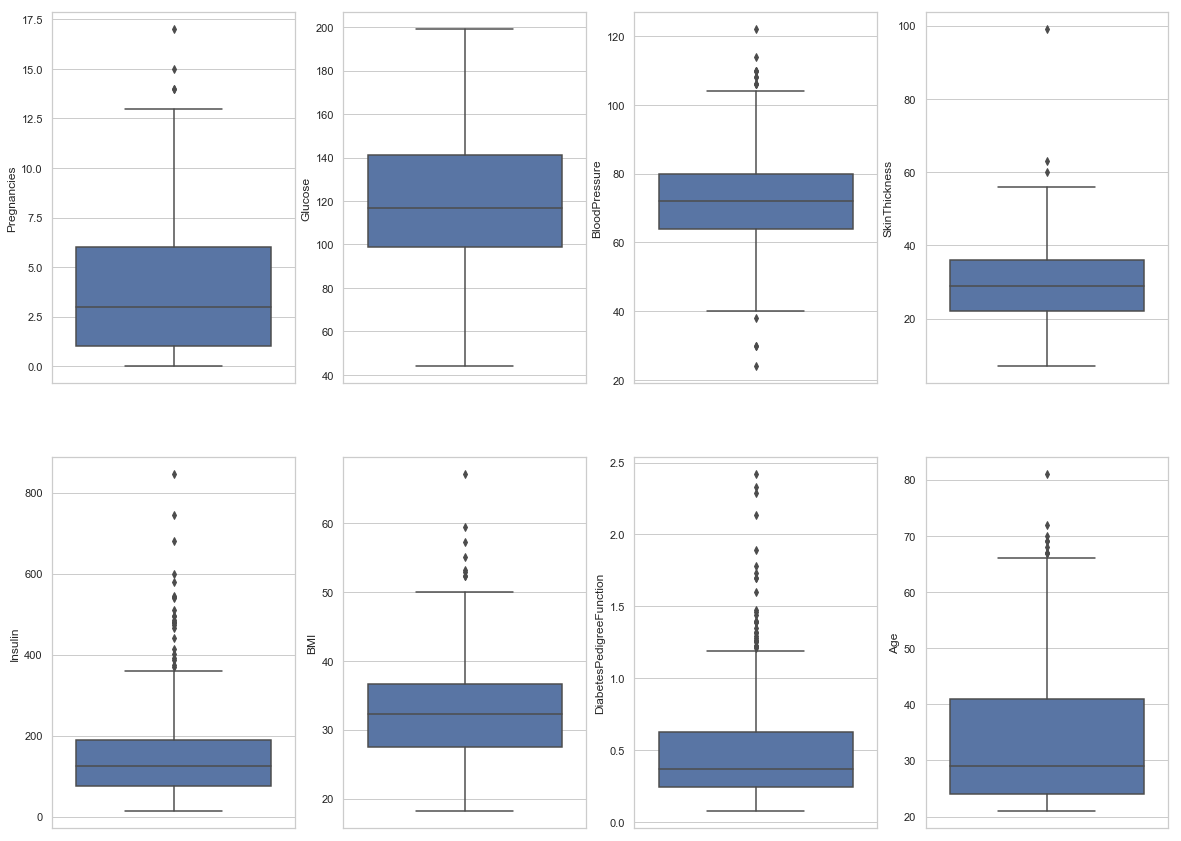

In [39]:
col = diabetes_nan.drop(['Outcome'], axis=1).columns
fig, ax = plt.subplots(2,4,figsize=(20,15))
for i,j in enumerate(col):
    if i <= 3:
        sns.boxplot(x=j, data=diabetes_nan, orient='v', ax=ax[0,i])
    else:
        sns.boxplot(x=j, data=diabetes_nan, orient='v', ax=ax[1,i-4])

We can see that there are plenty of outliers exist in most of the columns, we will cap the upper bound at 1.5 times of IQR above the 3rd quantile and lower bound at 1.5 times of IQR below the 1st quantile

In [40]:
# calculate IQR for each column
IQR = diabetes_nan.quantile(0.75) - diabetes_nan.quantile(0.25)
print('IQR')
print(IQR)
upper = diabetes_nan.quantile(0.75) + 1.5*IQR
lower = diabetes_nan.quantile(0.25) - 1.5*IQR

IQR
Pregnancies                   5.0000
Glucose                      42.0000
BloodPressure                16.0000
SkinThickness                14.0000
Insulin                     113.7500
BMI                           9.1000
DiabetesPedigreeFunction      0.3825
Age                          17.0000
Outcome                       1.0000
dtype: float64


In [41]:
upper

Pregnancies                  13.500
Glucose                     204.000
BloodPressure               104.000
SkinThickness                57.000
Insulin                     360.625
BMI                          50.250
DiabetesPedigreeFunction      1.200
Age                          66.500
Outcome                       2.500
dtype: float64

In [42]:
lower

Pregnancies                 -6.500
Glucose                     36.000
BloodPressure               40.000
SkinThickness                1.000
Insulin                    -94.375
BMI                         13.850
DiabetesPedigreeFunction    -0.330
Age                         -1.500
Outcome                     -1.500
dtype: float64

In [43]:
# apply the cap to our data
diabetes_outliers_clean = diabetes_nan.copy()
for col in col:
    diabetes_outliers_clean[col] = diabetes_outliers_clean[col].apply(lambda x: min(x, upper[col]))
    diabetes_outliers_clean[col] = diabetes_outliers_clean[col].apply(lambda x: max(x, lower[col]))

After cleaning the outliers, we will replot the boxplots above to confirm our cleaning step

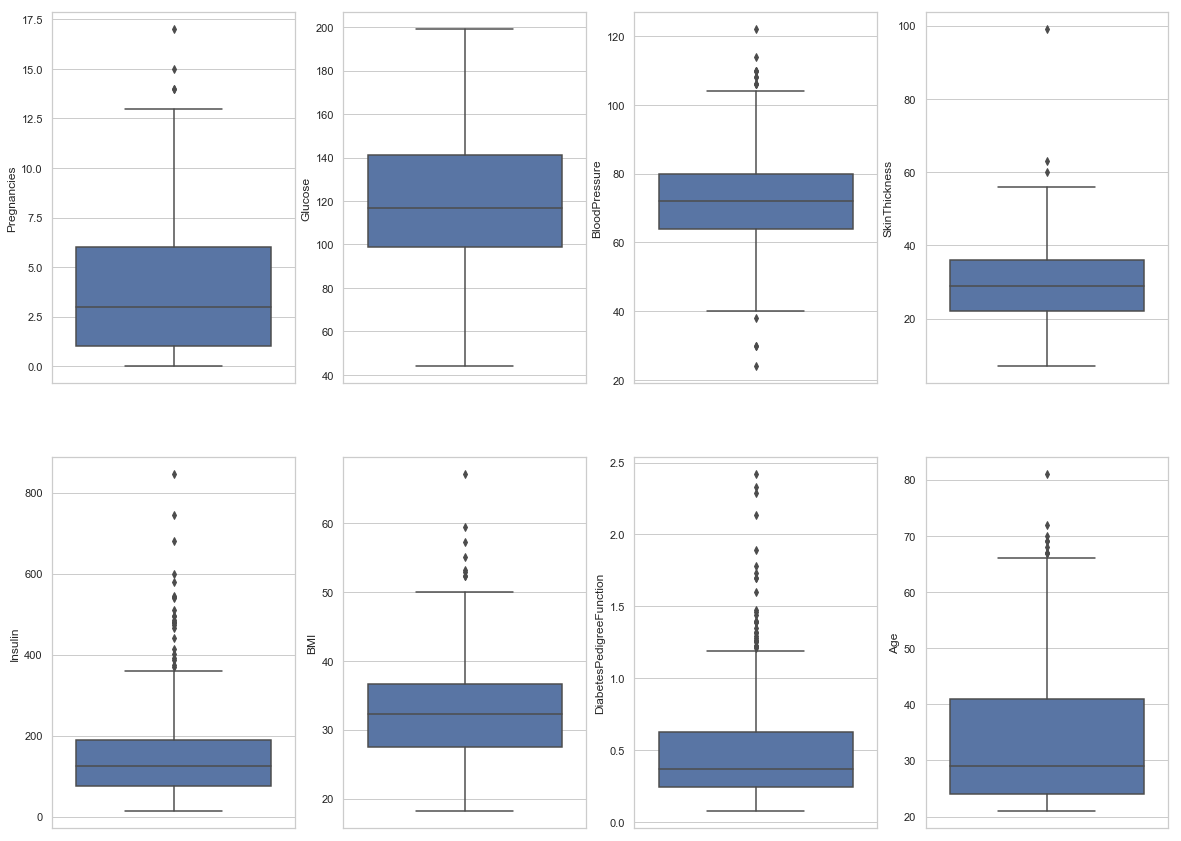

In [44]:
col = diabetes_outliers_clean.drop(['Outcome'], axis=1).columns
fig, ax = plt.subplots(2,4,figsize=(20,15))
ax = ax.flatten()
for i,j in enumerate(col):
    sns.boxplot(x=j, data=diabetes_nan, orient='v', ax=ax[i])    

In [45]:
# update the first approach from our new diabetes_outliers_clean
diabetes2 = diabetes_outliers_clean.dropna()
diabetes2.shape

(392, 9)

### Influence of dropping missing value and cleaning outliers
Before proceeding, we will do some plotting to show the influence of dropping missing value rows and after cleaning outliers

#### dropping rows with missing values vs no drop

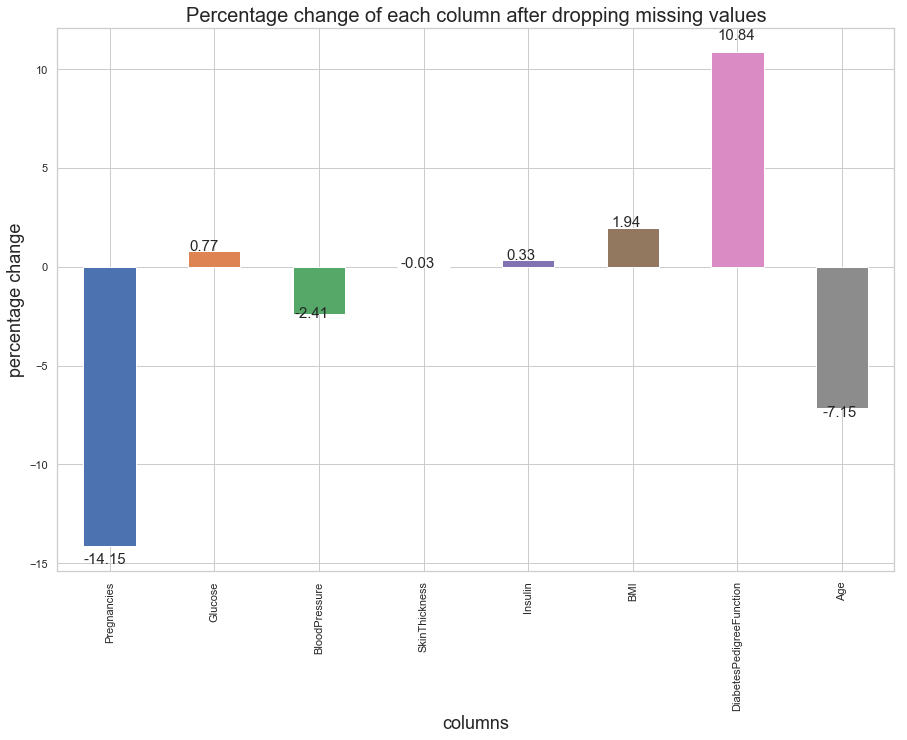

In [46]:
# percentage change after dropping rows with missing valueb
diff_1 = (diabetes1.mean() - diabetes_nan.mean()) / diabetes_nan.mean() * 100
fig, ax = plt.subplots(1,1,figsize=(15,10))
ax = diff_1.drop(['Outcome'], axis=0).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x()*1.01, p.get_height()*1.06), size=15)
ax.set_xlabel('columns',size=18)
ax.set_ylabel('percentage change', size=18)
ax.set_title('Percentage change of each column after dropping missing values', size=20)
plt.show()

From the graph above, we can see that pregnancies has almost 14% drop after dropping rows with missing values, this is quite a big change, thus we might want to consider keeping as many rows as possible

#### Cleaning outliers vs non-cleaning

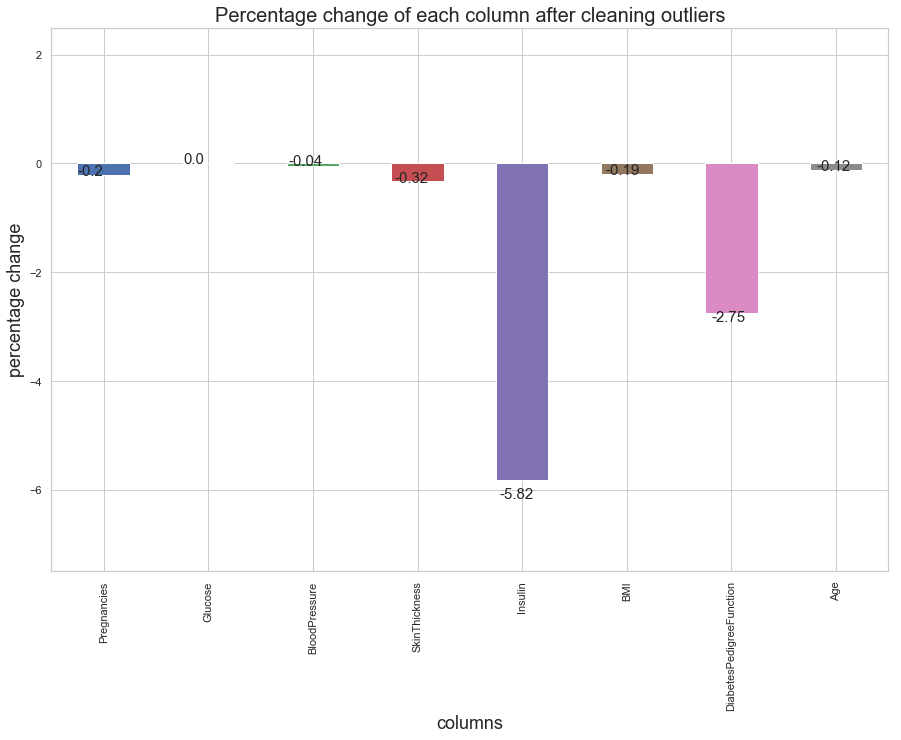

In [47]:
# percentage changes of each column before and after cleaning outliers
diff_2 = (diabetes_outliers_clean.mean() - diabetes_nan.mean()) / diabetes_nan.mean() * 100
fig, ax = plt.subplots(1,1,figsize=(15,10))
ax = diff_2.drop(['Outcome'], axis=0).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x()*1.01, p.get_height()*1.06), size=15)
ax.set_xlabel('columns',size=18)
ax.set_ylabel('percentage change', size=18)
ax.set_title('Percentage change of each column after cleaning outliers', size=20)
ax.set_ylim(-7.5,2.5)
plt.show()

We can see from above that the percentage did not change much after cleaning up outliers, the column `Insulin` has the largest change by dropping 5.82%

We are now ready to impute the missing values, before doing so, we have to split our dataset into training and testing since we will have to use the imputing values from the training set and apply to the testing(the new data we have never seen before), we will import the packages from sklearn to assist our goal

In [48]:
# import package for imputing and splitting
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes_outliers_clean.drop(['Outcome'], axis=1),
                                                    diabetes_outliers_clean['Outcome'],
                                                    test_size=0.3,
                                                    stratify=diabetes_outliers_clean['Outcome'],
                                                    random_state=1009)

#### Impute with mean

In [49]:
impute = SimpleImputer(strategy='mean')
X_train_mean = X_train.copy()
X_test_mean = X_test.copy()

cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

X_train_mean[cols] = impute.fit_transform(X_train_mean[cols])
X_test_mean[cols] = impute.transform(X_test_mean[cols]) # use the mean value from train set on test set

#### Impute with median

In [50]:
impute = SimpleImputer(strategy='median')
X_train_median = X_train.copy()
X_test_median = X_test.copy()

X_train_median[cols] = impute.fit_transform(X_train_median[cols])
X_test_median[cols] = impute.transform(X_test_median[cols]) # use the mean value from train set on test set

At this point, we are now ready to save our processed data for future use, the next step we will be performing is the exploratory data analysis

In [51]:
# exporting the processed data
diabetes_outliers_clean.to_csv('../Data/diabetes_outliers_clean.csv', index=False)
diabetes2.to_csv('../Data/diabetes_drop_nan.csv', index=False)
X_train_mean.to_csv('../Data/diabetes_mean_X_train.csv', index=False)
X_train_median.to_csv('../Data/diabetes_median_X_train.csv', index=False)
X_test_mean.to_csv('../Data/diabetes_mean_X_test.csv', index=False)
X_test_median.to_csv('../Data/diabetes_median_X_test.csv', index=False)
y_train.to_csv('../Data/diabetes_y_train.csv', index=False)
y_test.to_csv('../Data/diabetes_y_test.csv', index=False)

In [57]:
y_train

302    0
614    1
468    1
615    0
578    0
15     1
759    1
390    0
559    0
78     1
45     1
287    1
102    0
666    1
207    1
357    1
766    1
87     0
611    1
246    0
300    1
197    1
694    0
100    1
688    0
331    0
314    1
313    0
295    0
479    0
      ..
229    0
447    0
216    1
117    0
107    0
705    0
342    0
603    1
637    0
256    0
502    1
544    0
470    0
203    0
11     1
423    0
635    1
525    0
261    1
554    0
531    0
538    0
616    0
181    0
751    0
252    0
703    0
244    0
321    1
317    1
Name: Outcome, Length: 537, dtype: int64